In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize
from torchdiffeq import odeint  # Neural ODE Solver
import random
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from scipy.stats import gamma, weibull_min
from scipy.ndimage import gaussian_filter1d
from scipy.stats import norm
from scipy.signal import savgol_filter

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

def seed_everything(seed=42):
    # Python built-in random module
    random.seed(seed)
    np.random.seed(seed)
    # PyTorch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    # For deterministic behavior (may impact performance)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed for reproducibility
seed_everything(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
print(f"Using {device} device")

Using cuda device


# Data load

In [ ]:
def adjust_week(row):
    if (row['year'] == 2017)|(row['year'] == 2018)|(row['year'] == 2023)|(row['year'] == 2024):
        return row['week'] + 1
    elif (row['year'] == 2026):
        return row['week'] - 1
    return row['week']

In [ ]:
# Enable GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset
file_path = "../../../data/KDCA_influenza_ili_virus_2.xlsx"
matlab_path = "../../MATLAB/pinn_simulation_100_new/"
df = pd.read_excel(file_path, sheet_name="Sheet1")

ili_max_index = df['ILI'].idxmax()

train_start_week = 0
df = df[train_start_week:].reset_index(drop=True)

df['adjust_week'] = df.apply(adjust_week, axis=1)
df['date'] = df['year'].astype(int).astype(str) + '-' + df['adjust_week'].astype(int).astype(str)
df['date'] = pd.to_datetime(df['date'] + '-1', format='%Y-%W-%w')-pd.Timedelta(days=8)

df["index"] = np.arange(1, len(df) + 1)
df = df.set_index('date').iloc[19:92,].reset_index()
df_raw = df.copy()
df

Using device: cuda


,date,year-week,year,week,ILI,virusA_sum,virusA_avg,virusB_sum,virusB_avg,virus_sum,virus_avg,virus_cum,virus_log10,viral_total_sum_log_cum,Index,ILI_A,adjust_week,index
0,2024-03-03,2024-10,2024,10,12.8,4.341284e+07,5.107393e+05,1.281742e+07,1.507931e+05,5.623026e+07,6.615324e+05,2.138563e+10,7.749970,166.879153,20,4.042105,11,20
1,2024-03-10,2024-11,2024,11,15.1,2.716127e+08,3.527438e+06,5.791321e+06,7.521196e+04,2.774041e+08,3.602650e+06,2.166303e+10,8.443113,175.322265,21,3.775000,12,21
2,2024-03-17,2024-12,2024,12,13.8,6.250020e+07,7.267465e+05,3.123783e+07,3.632305e+05,9.373803e+07,1.089977e+06,2.175677e+10,7.971916,183.294181,22,6.272727,13,22
3,2024-03-24,2024-13,2024,13,14.0,1.894288e+08,2.202661e+06,4.423727e+08,5.143868e+06,6.318015e+08,7.346529e+06,2.238857e+10,8.800581,192.094762,23,3.600000,14,23
4,2024-03-31,2024-14,2024,14,13.8,4.281953e+08,5.286361e+06,1.125945e+08,1.390055e+06,5.407897e+08,6.676417e+06,2.292936e+10,8.733028,200.827790,24,5.276471,15,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,2025-06-22,2025-26,2025,26,4.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,667.801507,88,1.400000,26,88
69,2025-06-29,2025-27,2025,27,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,673.197417,89,1.500000,27,89
70,2025-07-06,2025-28,2025,28,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,678.517638,90,2.000000,28,90
71,2025-07-13,2025-29,2025,29,4.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,683.677428,91,0.000000,29,91


In [68]:
df_train = df_raw.set_index('date').iloc[:57,].reset_index()
df_train_raw = df_train.copy()

df_test = df_raw.iloc[57:,].reset_index(drop=True)
df_test_raw = df_test.copy()

In [71]:
forecast_weeks = len(df_test['date'])
forecast_weeks

16

In [72]:
forecast_start_date = df_test['date'].iloc[0]
forecast_end_date = df_test['date'].iloc[-1]

print(f"Forecasting from {forecast_start_date} to {forecast_end_date}")

Forecasting from 2025-04-06 00:00:00 to 2025-07-20 00:00:00


In [ ]:
df_train['date'] = pd.to_datetime(df_train['date'])
df_test['date'] = pd.to_datetime(df_test['date'])

# MLP

In [ ]:
t_train_PINN = torch.tensor(df_train["index"].values, dtype=torch.float32).view(-1, 1).to(device)
V_train = torch.tensor(df_train["viral_total_sum_log_cum"].values, dtype=torch.float32).view(-1, 1).to(device)
V_train_norm = V_train / V_train.max()

In [ ]:
# =============================================================================
# Weight Initialization Functions
# =============================================================================
def create_custom_identity_matrix(rows, cols):
    if rows >= cols:
        identity_matrix = np.eye(rows, cols, dtype=np.float32)
    else:
        identity_matrix = np.zeros((cols, rows), dtype=np.float32)
        for i in range(cols):
            identity_matrix[i, i % rows] = 1
        identity_matrix = identity_matrix.transpose()
    std = 0.085 * (1 / np.sqrt(cols))
    noise = np.random.normal(0, std, size=(rows, cols))
    identity_matrix += noise
    return identity_matrix

def custom_identity_initializer(m):
    if isinstance(m, nn.Linear):
        m_shape = m.weight.shape
        identity_matrix = create_custom_identity_matrix(m_shape[0], m_shape[1])
        m.weight.data.copy_(torch.tensor(identity_matrix, dtype=torch.float32))
        if m.bias is not None:
            nn.init.zeros_(m.bias)

def init_weights_xavier(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# =============================================================================
# Generalized MLP Builder (customizable)
# =============================================================================
def build_mlp(input_dim, output_dim, hidden_layers, hidden_nodes, activation):
    layers = []
    prev = input_dim
    for _ in range(hidden_layers):
        layers.append(nn.Linear(prev, hidden_nodes))
        if activation.lower() == 'relu':
            layers.append(nn.ReLU())
        elif activation.lower() == 'tanh':
            layers.append(nn.Tanh())
        elif activation.lower() == 'softplus':
            layers.append(nn.Softplus())
        elif activation.lower() == 'sigmoid':
            layers.append(nn.sigmoid())
        elif activation.lower() in ['silu', 'swish']:
            layers.append(nn.SiLU())
        else:
            layers.append(nn.ReLU())  # default
        prev = hidden_nodes
    layers.append(nn.Linear(prev, output_dim))
    return nn.Sequential(*layers)

# =============================================================================
# 1. MLP Models for I(t) and V(t)
# =============================================================================
    
class MLP_V(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, hidden_layers=6, hidden_nodes=256, activation='softplus'):
        super(MLP_V, self).__init__()
        self.net = build_mlp(input_dim, output_dim, hidden_layers, hidden_nodes, activation)
        self.apply(init_weights_xavier)
    def forward(self, t):
        # Ensure input has shape [batch_size, 1]
        if t.dim() == 0:
            t = t.unsqueeze(0)
        if t.dim() == 1:
            t = t.unsqueeze(1)
        return self.net(t)


mlp_V = MLP_V().to(device)

def train_mlp_model(model, t_PINN, target_norm, name="MLP", epochs=1000, print_every=100):
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-5)
    loss_fn = nn.MSELoss()
    loss_history = []
    
    # Early stopping parameters
    patience = 100000  # Number of epochs to wait for improvement
    min_delta = 1e-12  # Minimum change in loss to qualify as an improvement
    best_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        pred = model(t_PINN)
        train_loss = loss_fn(pred, target_norm)
        loss = train_loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        loss_history.append(loss.item())
        
        # Early stopping check
        if loss.item() < best_loss - min_delta:
            best_loss = loss.item()
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"{name} Early stopping triggered at epoch {epoch}")
            # Restore best model
            if best_model_state is not None:
                model.load_state_dict(best_model_state)
            break
            
        if epoch % print_every == 0:
            print(f"{name} Epoch {epoch}, Loss: {loss.item():.12f}")
    
    return loss_history, epoch + 1  # Return history and number of epochs trained

mlp_V_loss_history, mlp_V_epochs = train_mlp_model(mlp_V, t_train_PINN, V_train_norm, name="MLP_V", epochs=10000, print_every=500) 

MLP_V Epoch 0, Loss: 1.767971873283
MLP_V Epoch 500, Loss: 0.000079450132
MLP_V Epoch 1000, Loss: 0.000029058514
MLP_V Epoch 1500, Loss: 0.000010831611
MLP_V Epoch 2000, Loss: 0.000006635315
MLP_V Epoch 2500, Loss: 0.000005479390
MLP_V Epoch 3000, Loss: 0.000005097031
MLP_V Epoch 3500, Loss: 0.000005044073
MLP_V Epoch 4000, Loss: 0.000004970112
MLP_V Epoch 4500, Loss: 0.000004849596
MLP_V Epoch 5000, Loss: 0.000004908659
MLP_V Epoch 5500, Loss: 0.000006096571
MLP_V Epoch 6000, Loss: 0.000004468850
MLP_V Epoch 6500, Loss: 0.000004380487
MLP_V Epoch 7000, Loss: 0.000004327702
MLP_V Epoch 7500, Loss: 0.000004289269
MLP_V Epoch 8000, Loss: 0.000004257598
MLP_V Epoch 8500, Loss: 0.000004232665
MLP_V Epoch 9000, Loss: 0.000004214826
MLP_V Epoch 9500, Loss: 0.000004203556


## Train result

In [ ]:
t_train_PINN = torch.tensor(df_train["index"].values, dtype=torch.float32).view(-1, 1).to(device)
t_train_np = t_train_PINN.cpu().detach().numpy().flatten()

V_train_pred_norm = mlp_V(t_train_PINN).detach().cpu().numpy()
V_train_pred = V_train_pred_norm * V_train.max().item()

In [ ]:
mlp_loss_histories = {
    'Epoch' : np.arange(1, len(mlp_V_loss_history)+1),
    'MLP_V_Loss': mlp_V_loss_history
}
lr_histories = pd.DataFrame(mlp_loss_histories)
lr_histories
lr_histories.to_excel(matlab_path + "mlp_loss_histories.xlsx", index=False)

In [ ]:
df_train['V_MLP'] = V_train_pred
df_train.head()
df_train.to_excel(matlab_path + "mlp_V_histories.xlsx", index=False)

# WBE-PINN

## PINN Model

In [ ]:
# Add small epsilon to avoid division by zero
epsilon = 1e-6

# --- TRAINING DATA ---
I_train_raw = df_train["ILI"].values
I_train = torch.tensor(
    I_train_raw + epsilon,
    dtype=torch.float32
).view(-1, 1).to(device)

t_train_np = t_train_PINN.detach().cpu().numpy().flatten()

# Combine full time and ILI for plotting
t_all = t_train_np
I_all_raw = I_train_raw

In [ ]:
dates = df_train['date']
incidence = df_train['ILI'].values
n_weeks = len(incidence)

In [ ]:
# Weekly Rt

mu_days = 3.6
sigma_days = 1.6
mu = mu_days / 7
sigma = sigma_days / 7
distribution = "weibull" 

def solve_weibull(mu, sigma):
    from scipy.optimize import minimize_scalar
    from scipy.special import gamma as gamma_fn

    def objective(log_shape):
        shape = np.exp(log_shape)
        g1 = gamma_fn(1 + 1 / shape)
        g2 = gamma_fn(1 + 2 / shape)
        sigma_theory = np.sqrt((mu**2 / g1**2) * (g2 - g1**2))
        return (sigma_theory - sigma) ** 2

    result = minimize_scalar(objective, bounds=(np.log(1e-3), np.log(1e3)), method='bounded')
    shape = np.exp(result.x)
    scale = mu / gamma_fn(1 + 1 / shape)
    return shape, scale

if distribution == "gamma":
    shape_val = mu**2 / sigma**2
    scale_val = sigma**2 / mu
    si_probs = gamma.cdf(np.arange(1, 16), shape_val, scale=scale_val) - \
               gamma.cdf(np.arange(0, 15), shape_val, scale=scale_val)
else:
    shape_val, scale_val = solve_weibull(mu, sigma)
    si_probs = weibull_min.cdf(np.arange(1, 16), c=shape_val, scale=scale_val) - \
               weibull_min.cdf(np.arange(0, 15), c=shape_val, scale=scale_val)

si_probs = np.maximum(si_probs, 0)
si_probs = si_probs / si_probs.sum()
si_probs = np.insert(si_probs, 0, 0)

R_t_raw = []
for t in range(1, n_weeks):
    if t < len(si_probs):
        lambda_t = sum(incidence[:t][::-1] * si_probs[1:t+1])
    else:
        lambda_t = sum(incidence[t - len(si_probs)+1:t][::-1] * si_probs[1:])
    R = incidence[t] / lambda_t if lambda_t > 0 else np.nan
    R_t_raw.append(R)
R_t_raw = np.insert(R_t_raw, 0, np.nan)

R_t_series = pd.Series(R_t_raw)
R_t_smooth = gaussian_filter1d(R_t_series.values, sigma=1)
R_t_smoothed_series = pd.Series(R_t_smooth, index=R_t_series.index)
R_t_interpolated = R_t_smoothed_series.interpolate(method='linear', limit_direction='both', limit_area='outside')

df_Rt = pd.DataFrame({'Date': dates, 'R_t': R_t_interpolated})
df_Rt.set_index('Date', inplace=True)

In [83]:
rt = torch.tensor(df_Rt['R_t'].values, dtype=torch.float32).to(device)
rt

tensor([0.9199, 0.9199, 0.9199, 0.9199, 0.9199, 0.9199, 0.8979, 0.8893, 0.8923,
        0.9214, 0.9548, 0.9681, 0.9625, 0.9467, 0.9442, 0.9749, 1.0142, 1.0340,
        1.0380, 1.0475, 1.0946, 1.1330, 1.1065, 1.0279, 0.9337, 0.8464, 0.8250,
        0.8947, 0.9486, 0.8967, 0.8859, 0.9532, 0.9947, 1.0025, 1.0147, 1.0501,
        1.0893, 1.1217, 1.2173, 1.4522, 1.8264, 2.1145, 2.0074, 1.5094, 1.0168,
        0.7590, 0.6910, 0.6764, 0.6614, 0.7333, 0.8335, 0.9139, 1.0261, 1.1738,
        1.2293, 1.1832, 1.1130], device='cuda:0')

In [84]:
normalized_rt = rt / rt.max()
normalized_rt

tensor([0.4350, 0.4350, 0.4350, 0.4350, 0.4350, 0.4350, 0.4246, 0.4206, 0.4220,
        0.4357, 0.4515, 0.4579, 0.4552, 0.4477, 0.4465, 0.4610, 0.4796, 0.4890,
        0.4909, 0.4954, 0.5177, 0.5358, 0.5233, 0.4861, 0.4416, 0.4003, 0.3902,
        0.4231, 0.4486, 0.4241, 0.4190, 0.4508, 0.4704, 0.4741, 0.4799, 0.4966,
        0.5151, 0.5305, 0.5757, 0.6868, 0.8637, 1.0000, 0.9493, 0.7138, 0.4809,
        0.3589, 0.3268, 0.3199, 0.3128, 0.3468, 0.3942, 0.4322, 0.4853, 0.5551,
        0.5814, 0.5596, 0.5264], device='cuda:0')

In [ ]:
N=1000
I0 = I_train[0].item()
E0 = 0
R0 = 0
S0 = N - I0 - E0 - R0

S0, E0, I0, R0 = S0/N, E0/N, I0/I_train.max().item(), R0/N

# =============================================================================
# Generalized MLP Builder (customizable)
# =============================================================================
def build_pinn(input_dim, output_dim, hidden_layers, hidden_nodes, activation):
    layers = []
    prev = input_dim
    for _ in range(hidden_layers):
        layers.append(nn.Linear(prev, hidden_nodes))
        if activation.lower() == 'relu':
            layers.append(nn.ReLU())
        elif activation.lower() == 'tanh':
            layers.append(nn.Tanh())
        elif activation.lower() == 'softplus':
            layers.append(nn.Softplus())
        elif activation.lower() == 'sigmoid':
            layers.append(nn.Sigmoid())
        elif activation.lower() in ['silu', 'swish']:
            layers.append(nn.SiLU())
        else:
            layers.append(nn.ReLU())  # default
        prev = hidden_nodes
    layers.append(nn.Linear(prev, output_dim))
    return nn.Sequential(*layers)

# =============================================================================
# 2. PINN Models for S, E, I, R and parameter beta functions (customizable)
# =============================================================================
class PINN(nn.Module):
    def __init__(self, input_dim=1, output_dim=5, hidden_layers=48, hidden_nodes=32, activation='tanh'):
        super(PINN, self).__init__()
        self.net = build_pinn(input_dim, output_dim, hidden_layers, hidden_nodes, activation)
        # self.beta_net = build_pinn(1, 1, 3, 128, 'sigmoid')
        self.apply(custom_identity_initializer)
    def forward(self, t):
        output = self.net(t)
        return torch.sigmoid(output)  # normalize to (0,1) range
    def get_beta(self, t):
        raw_beta = self.beta_net(t) 
        # beta_clipped = torch.clip(raw_beta, min=0.0, max=50.0)
        return raw_beta  # time-dependent infection rate

#------------------------------------------------------------------------------------------------------------------#

def pinn_loss(model, t, kappa_sample, delta_sample, λ_data=1, λ_S=1, λ_R=1, λ_Reff=1, λ_phy= 1, λ_beta = 1, alpha=2.0):
    
    S, E, I, R, Rt = model(t).T
    I_raw = I
    I = I * (I_train.max().item() / N)

    kappa_tensor = torch.tensor(kappa_sample, dtype=torch.float32).view(-1, 1).to(t.device)
    delta_tensor = torch.tensor(delta_sample, dtype=torch.float32).view(-1, 1).to(t.device)
    Rt_real = Rt * rt.max().item()

    beta = (Rt_real*(delta_tensor.item()/S)).view(-1, 1)

    dS_dt = torch.autograd.grad(S, t, grad_outputs=torch.ones_like(S), create_graph=True)[0]
    dE_dt = torch.autograd.grad(E, t, grad_outputs=torch.ones_like(E), create_graph=True)[0]
    dI_dt = torch.autograd.grad(I, t, grad_outputs=torch.ones_like(I), create_graph=True)[0]
    dR_dt = torch.autograd.grad(R, t, grad_outputs=torch.ones_like(R), create_graph=True)[0]
    
    # (i) Data fitting loss    
    t_norm = (t / t.max()).squeeze()
    w_time = torch.exp(alpha * (t_norm - 1.0))
    target_I = I_train.flatten() / I_train.max()
    data_loss = ((I_raw.squeeze() - target_I)**2 * w_time).mean()

    # (ii) Physics loss
    phy_loss = torch.mean((dS_dt + beta.flatten()*S.flatten()*I.flatten())**2) + \
               torch.mean((dE_dt - beta.flatten()*S.flatten()*I.flatten() + kappa_tensor.item()*E.flatten())**2) + \
               torch.mean((dI_dt - kappa_tensor.item()*E.flatten() + delta_tensor.item()*I.flatten())**2) + \
               torch.mean((dR_dt - delta_tensor.item()*I.flatten())**2)

    # (iii) S_constraint
    S_loss = torch.mean(torch.relu(dS_dt))
    
    # (iv) R_constraint
    R_loss = torch.mean(torch.relu(-dR_dt))
                                                          
    
    # (vi) R_eff loss
    Reff_loss = torch.mean((Rt - normalized_rt)**2)
    
    # beta , R loss
    dRt_dt = torch.diff(rt, dim=-1) # (T-1)개의 요소
    dbeta_dt = torch.diff(beta.squeeze(), dim=-1) # (T-1)개의 요소
    beta_loss = torch.mean(torch.relu(-dRt_dt * dbeta_dt))

    total_loss = λ_data * data_loss + λ_S * S_loss + λ_R * R_loss + λ_Reff * Reff_loss + λ_phy * phy_loss + λ_beta * beta_loss

    return phy_loss, data_loss, total_loss

#------------------------------------------------------------------------------------------------------------------#

# Initialize model & optimizer
model = PINN()
model.train()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)  # Reduce LR every 1000 epochs

# Apply initial conditions in training
def initial_conditions():
    return torch.tensor([[S0, E0, I0, R0, normalized_rt[0].item()]], dtype=torch.float32)

In [ ]:
import itertools

hidden_layers = [48]
hidden_nodes = [128]
λ_data_list = [10]
λ_S_list = [10]
λ_R_list = [10]
λ_phy_list = [5]
λ_beta_list = [10]
λ_Reff_list = [20]
epoch_list = [5000]
learning_rate_list = [0.00001]

param_grid = list(itertools.product(hidden_layers, hidden_nodes, epoch_list, learning_rate_list, λ_data_list, λ_S_list, λ_R_list, λ_Reff_list, λ_ode_list, λ_beta_list))

results = []

hidden_layer=48, hidden_node=128, epoch=5000, learning_rate=1e-05, λ_data=10, λ_S=10, λ_R=10, λ_beta=20, λ_ode=5, λ_beta_R=10
Running iteration 1 of 100...
Final loss (rep 1): 0.009130 | κ = 1.8595, δ = 0.6443
Running iteration 2 of 100...
Final loss (rep 2): 0.008424 | κ = 1.6627, δ = 0.6558
Running iteration 3 of 100...
Final loss (rep 3): 0.021819 | κ = 1.5589, δ = 1.4589
Running iteration 4 of 100...
Final loss (rep 4): 0.025538 | κ = 1.1153, δ = 1.6819
Running iteration 5 of 100...
Final loss (rep 5): 0.017800 | κ = 1.8940, δ = 1.2894
Running iteration 6 of 100...
Final loss (rep 6): 0.019356 | κ = 1.5760, δ = 1.3198
Running iteration 7 of 100...
Final loss (rep 7): 0.028375 | κ = 1.2260, δ = 1.7893
Running iteration 8 of 100...
Final loss (rep 8): 0.009811 | κ = 2.3513, δ = 0.7211
Running iteration 9 of 100...
Final loss (rep 9): 0.013267 | κ = 1.9866, δ = 1.0784
Running iteration 10 of 100...
Final loss (rep 10): 0.017966 | κ = 2.0023, δ = 1.3642
Running iteration 11 of 100...
F

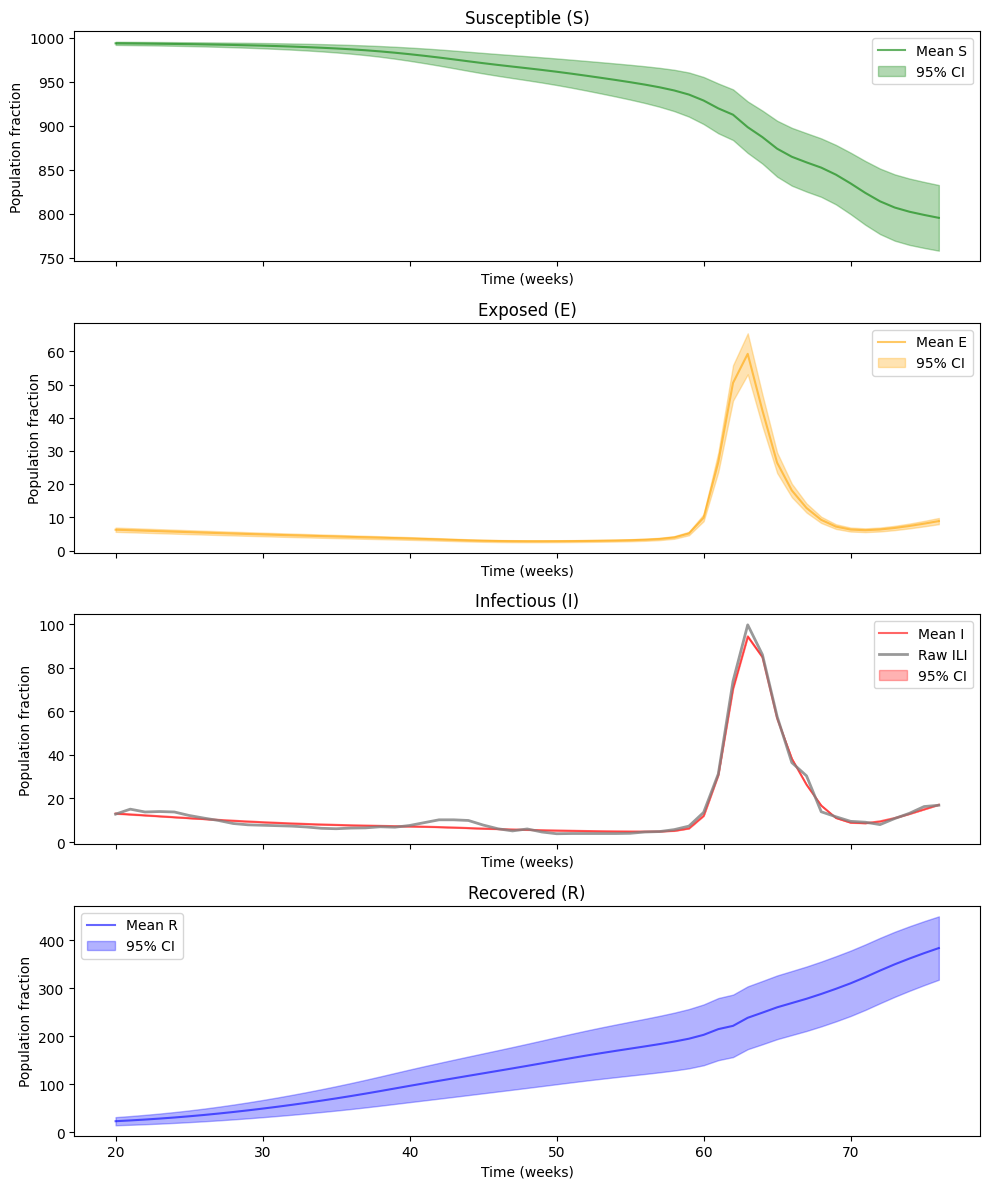

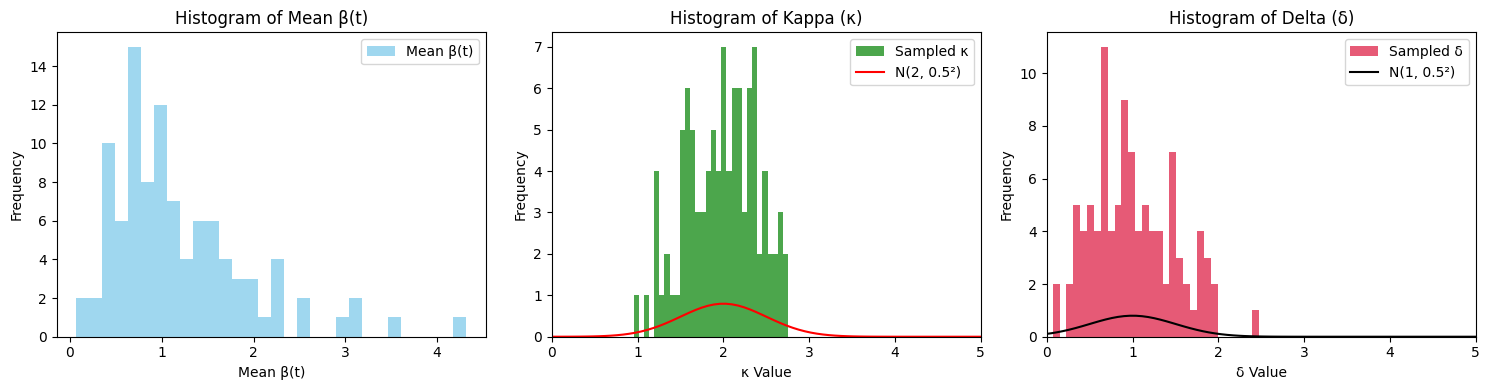

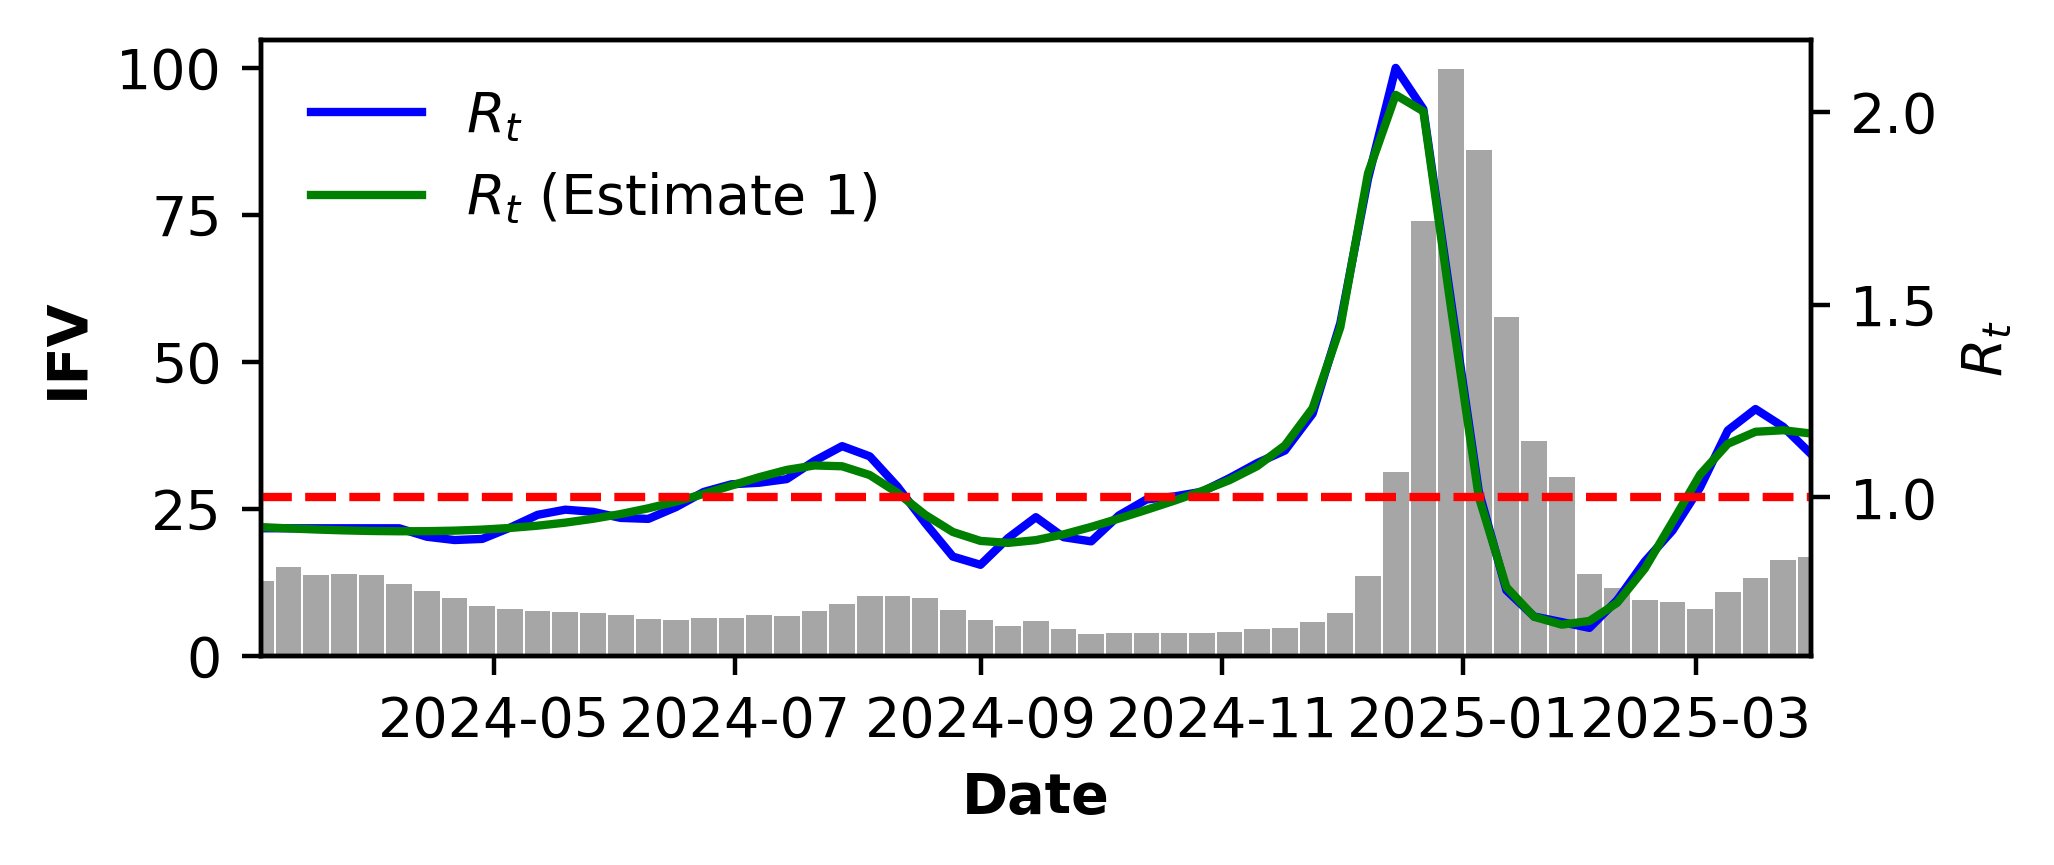

In [ ]:
for hidden_layer, hidden_node, epoch, learning_rate, λ_data, λ_S, λ_R, λ_Reff, λ_phy, λ_beta in param_grid:
    ## Save the model for each reps
    rep_models = []
    
    print(f"hidden_layer={hidden_layer}, hidden_node={hidden_node}, "
          f"epoch={epoch}, learning_rate={learning_rate}, "
          f"λ_data={λ_data}, "
          f"λ_S={λ_S}, λ_R={λ_R}, "
          f"λ_Reff={λ_Reff}, λ_phy={λ_phy}, λ_beta={λ_beta}"
         )
    
    loss_histories = []
    beta_histories = []
    kappa_histories = []
    delta_histories = []
    pinn_train_histories = []
    pinn_test_histories = []
    lr_histories = []
    all_loss_records = []

    num_sample_parameters = 100
    num_epoch = epoch

    for rep in range(num_sample_parameters):
        print(f"Running iteration {rep+1} of {num_sample_parameters}...")
        
        torch.cuda.empty_cache() # Clear GPU memory before each run (cashe reset)

        model = PINN(hidden_layers=hidden_layer, hidden_nodes=hidden_node).to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)

        loss_history = []
        beta_t_history = []
        
        # positive value
        while True:
            kappa_sampled = np.random.normal(2, 0.5, 1)
            if kappa_sampled > 0:
                break

        while True:
            delta_sampled = np.random.normal(1, 0.5, 1)
            if delta_sampled > 0:
                break

        for epoch in range(num_epoch):
            optimizer.zero_grad()
            loss_eqs, loss_data, loss_total = pinn_loss(
                model, t_train_PINN.requires_grad_(), kappa_sampled, delta_sampled, λ_data=λ_data, λ_S=λ_S, λ_R=λ_R, λ_Reff=λ_Reff, λ_phy=λ_phy, λ_beta=λ_beta
            )
            
            initial_loss = torch.mean(
                (model(torch.tensor([[0.0]], dtype=torch.float32).to(device)) - initial_conditions().to(device)) ** 2
            )
            loss_total += initial_loss

            loss_total.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()

            # Store learning metrics
            loss_history.append(loss_total.item())
            lr_histories.append(optimizer.param_groups[0]['lr'])
            # beta_sample = model.get_beta(t_train_PINN).detach().cpu().numpy().flatten()
            # beta_t_history.append(beta_sample)

            all_loss_records.append({'rep': rep, 'epoch': epoch, 'loss': loss_total.item()})

        # Print final loss summary
        print(f"Final loss (rep {rep+1}): {loss_history[-1]:.6f} | κ = {kappa_sampled[0]:.4f}, δ = {delta_sampled[0]:.4f}")

        # Save S, E, I, R predictions for the current model
        with torch.no_grad():
            y_pred = model(t_train_PINN).detach().cpu().numpy()
            pinn_train_histories.append({'S': y_pred[:, 0], 'E': y_pred[:, 1], 'I': y_pred[:, 2], 'R': y_pred[:, 3], 'Rt': y_pred[:, 4]})

        loss_histories.append(loss_history)
        # beta_histories.append(beta_t_history[-1])
        kappa_histories.append(kappa_sampled)
        delta_histories.append(delta_sampled)
        
        rep_models.append(model.cpu())

    train_I = np.array([history['I'] for history in pinn_train_histories]) * I_train.max().item()
    train_E = np.array([history['E'] for history in pinn_train_histories]) * N
    train_R = np.array([history['R'] for history in pinn_train_histories]) * N
    train_S = np.array([history['S'] for history in pinn_train_histories]) * N
    train_Rt = np.array([history['Rt'] for history in pinn_train_histories]) * rt.max().item()

    mean_train_I = np.mean(train_I, axis=0)
    std_train_I = np.std(train_I, axis=0)
    lower_bound_train_I = mean_train_I - 1.96 * std_train_I / np.sqrt(num_sample_parameters)
    upper_bound_train_I = mean_train_I + 1.96 * std_train_I / np.sqrt(num_sample_parameters)

    mean_train_S = np.mean(train_S, axis=0)
    std_train_S = np.std(train_S, axis=0)
    lower_bound_train_S = mean_train_S - 1.96 * std_train_S / np.sqrt(num_sample_parameters)
    upper_bound_train_S = mean_train_S + 1.96 * std_train_S / np.sqrt(num_sample_parameters)

    mean_train_E = np.mean(train_E, axis=0)
    std_train_E = np.std(train_E, axis=0)
    lower_bound_train_E = mean_train_E - 1.96 * std_train_E / np.sqrt(num_sample_parameters)
    upper_bound_train_E = mean_train_E + 1.96 * std_train_E / np.sqrt(num_sample_parameters)

    mean_train_R = np.mean(train_R, axis=0)
    std_train_R = np.std(train_R, axis=0)
    lower_bound_train_R = mean_train_R - 1.96 * std_train_R / np.sqrt(num_sample_parameters)
    upper_bound_train_R = mean_train_R + 1.96 * std_train_R / np.sqrt(num_sample_parameters)

    mean_train_Rt = np.mean(train_Rt, axis=0)
    std_train_Rt = np.std(train_Rt, axis=0)
    lower_bound_train_Rt = mean_train_Rt - 1.96 * std_train_Rt / np.sqrt(num_sample_parameters)
    upper_bound_train_Rt = mean_train_Rt + 1.96 * std_train_Rt / np.sqrt(num_sample_parameters)

    t_train_np2 = t_train_PINN.cpu().detach().numpy().flatten()

    # Plotting the predicted S, E, I, R values with mean, 95% CI
    fig, axes = plt.subplots(4, 1, figsize=(10, 12), sharex=True)
    titles = ["Susceptible (S)", "Exposed (E)", "Infectious (I)", "Recovered (R)", "Viral Load (V)"]
    colors = ["green", "orange", "red", "blue", "gray"]


    for i, ax in enumerate(axes):
        if i == 0:
            ax.plot(t_train_np2, mean_train_S, color=colors[i], label='Mean S', alpha=0.6)
            ax.fill_between(t_train_np2, lower_bound_train_S, upper_bound_train_S, color=colors[i], alpha=0.3, label='95% CI')
        elif i == 1:
            ax.plot(t_train_np2, mean_train_E, color=colors[i], label='Mean E', alpha=0.6)
            ax.fill_between(t_train_np2, lower_bound_train_E, upper_bound_train_E, color=colors[i], alpha=0.3, label='95% CI')
        elif i == 2:
            ax.plot(t_train_np2, mean_train_I, color=colors[i], label='Mean I', alpha=0.6)
            # ax.scatter(t_train_np2, I_train_raw, color="gray", alpha=0.6, label="Raw ILI")
            ax.plot(t_train_np2, I_train_raw, color="gray", alpha=0.8, linewidth=2, linestyle='-', label="Raw ILI")
            ax.fill_between(t_train_np2, lower_bound_train_I, upper_bound_train_I, color=colors[i], alpha=0.3, label='95% CI')
        elif i == 3:
            ax.plot(t_train_np2, mean_train_R, color=colors[i], label='Mean R', alpha=0.6)
            ax.fill_between(t_train_np2, lower_bound_train_R, upper_bound_train_R, color=colors[i], alpha=0.3, label='95% CI')
        
        # Set labels and titles
        ax.set_title(titles[i])
        ax.set_xlabel('Time (weeks)')
        ax.set_ylabel('Population fraction')
        ax.legend()
        # ax.grid(True)
        
    plt.tight_layout()
    plt.show()

    # === Extract scalar summaries from learned β(t) ===
    # beta_histories: list of arrays from model.get_beta(t) per training run
    # === Extract kappa and delta samples ===
    kappa_list = [kappa[0] for kappa in kappa_histories]
    delta_list = [delta[0] for delta in delta_histories]

    # === Plot ===
    fig, ax = plt.subplots(1, 3, figsize=(15, 4))

    # --- Plot 1: Mean β(t) ---
    delta_arr = np.array(delta_histories)
    kappa_arr = np.array(kappa_histories)
    beta_histories = (train_Rt * (delta_arr * N / train_S))
    # beta_means = np.mean(beta_histories, axis=1)
    beta_means = [np.mean(beta_t) for beta_t in beta_histories]   # mean of β(t) per run
    beta_stds = [np.std(beta_t) for beta_t in beta_histories]     # std of β(t) per run
    beta_final = [beta_t[-1] for beta_t in beta_histories]        # β(T) final value per run
    ax[0].hist(beta_means, bins=30, color='skyblue', alpha=0.8, label='Mean β(t)')
    ax[0].set_xlabel("Mean β(t)")
    ax[0].set_ylabel("Frequency")
    ax[0].set_title("Histogram of Mean β(t)")
    ax[0].legend()


    # --- Plot 2: Sampled Kappa (κ) ---
    ax[1].hist(kappa_list, bins=30, color='green', alpha=0.7, label='Sampled κ')
    x_k = np.linspace(-2, 5, 100)
    ax[1].plot(x_k, norm.pdf(x_k, 2, 0.5), color='red', label='N(2, 0.5²)')
    ax[1].set_xlabel("κ Value")
    ax[1].set_ylabel("Frequency")
    ax[1].set_title("Histogram of Kappa (κ)")
    ax[1].set_xlim(0, 5)
    ax[1].legend()

    # --- Plot 3: Sampled Delta (δ) ---
    ax[2].hist(delta_list, bins=30, color='crimson', alpha=0.7, label='Sampled δ')
    x_d = np.linspace(-2, 5, 100)
    ax[2].plot(x_d, norm.pdf(x_d, 1, 0.5), color='black', label='N(1, 0.5²)')
    ax[2].set_xlabel("δ Value")
    ax[2].set_ylabel("Frequency")
    ax[2].set_title("Histogram of Delta (δ)")
    ax[2].set_xlim(0, 5)
    ax[2].legend()

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(5, 2), dpi=400)

    plt.bar(df_train['date'], df_train['ILI'], width=6.5, label='ILI', color='gray', alpha=0.7)
    plt.xlabel('Date', fontsize=10, fontweight='bold')
    plt.ylabel('IFV', fontsize=10, fontweight='bold')
    plt.xlim(df_train['date'].min(), df_train['date'].max())

    ax2 = plt.gca().twinx()
    ax2.plot(df_Rt.index, df_Rt['R_t'], label='$R_t$', color='blue')
    ax2.plot(df_Rt.index, np.mean(train_Rt, axis=0), label='$R_t$ (Estimate 1)', color='green')
    ax2.set_ylabel(r'$R_t$')
    ax2.axhline(y=1, color='red', linestyle='--')

    plt.legend(frameon=False, loc='upper left')
    plt.show()

    ## Save the model
    results.append(rep_models)


In [ ]:
kappa_list = [kappa[0] for kappa in kappa_histories]
delta_list = [delta[0] for delta in delta_histories]

kappa_arr = np.array(kappa_histories)
delta_arr = np.array(delta_histories)

beta_histories = train_Rt * ((delta_arr * N / train_S))
beta_means = [np.mean(beta_t) for beta_t in beta_histories] 
beta_stds = [np.std(beta_t) for beta_t in beta_histories]   
beta_final = [beta_t[-1] for beta_t in beta_histories]  


## Train result

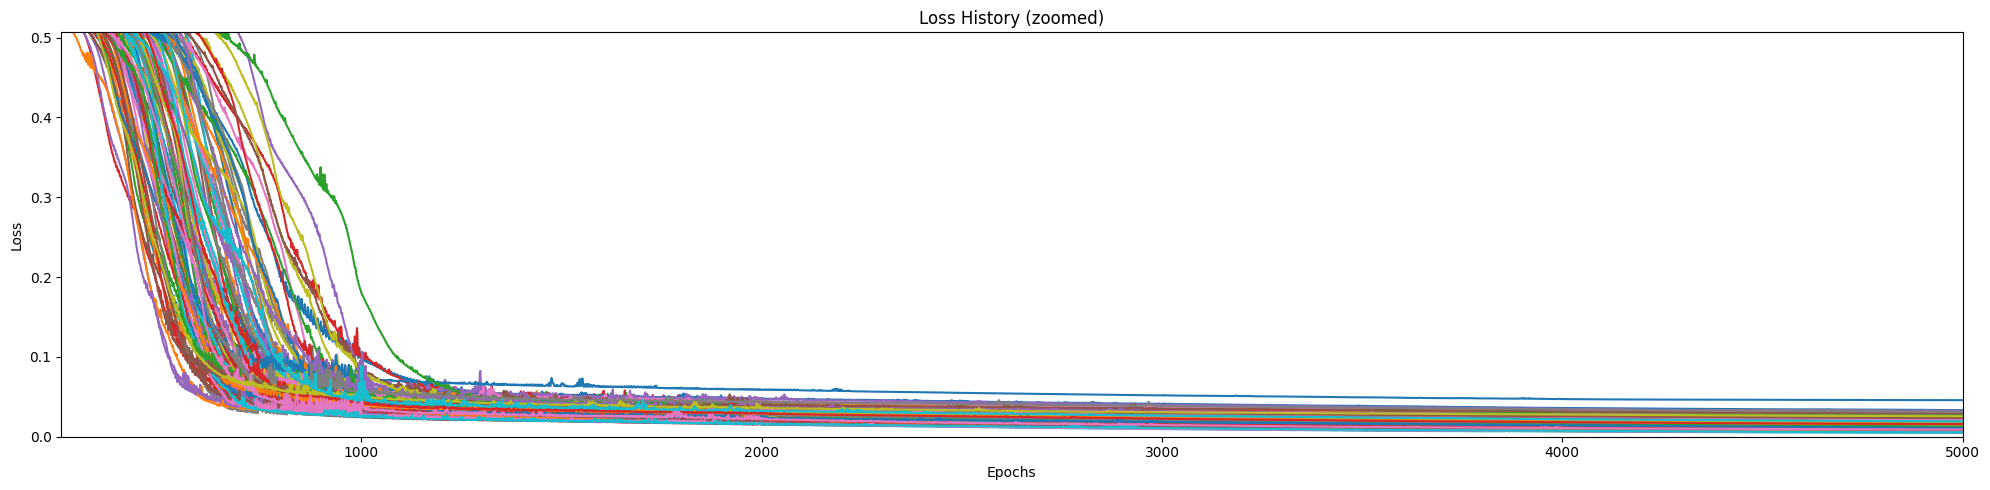

In [ ]:
# --- Determine a sensible ylim based on smoothed losses after warmup ---
warmup_cutoff = 250
flattened_losses = np.concatenate([lh[warmup_cutoff:] for lh in loss_histories])
y_upper = np.percentile(flattened_losses, 95)  # You can use 90, 95, or 98 based on zoom preference

# --- Plot ---
fig, axes = plt.subplots(figsize=(20, 5))

for i, history in enumerate(loss_histories):
    plt.plot(history, label=f"Run {i+1}")

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss History (zoomed)')
plt.xlim(warmup_cutoff, num_epoch)
plt.ylim(0, y_upper * 1.1)  # Add small buffer
# plt.legend()
plt.tight_layout()
plt.show()



In [92]:
a=[beta_t for beta_t in beta_histories]
a

[array([0.59954423, 0.59570785, 0.59246524, 0.58988428, 0.58803092,
        0.58697592, 0.58680264, 0.58760861, 0.58950216, 0.59260041,
        0.59701806, 0.6028601 , 0.61021196, 0.61912812, 0.62960845,
        0.6415485 , 0.65466363, 0.66836221, 0.681579  , 0.69258486,
        0.6987803 , 0.69653854, 0.68167729, 0.65267445, 0.61701563,
        0.58840464, 0.57327615, 0.56974084, 0.57404063, 0.58323818,
        0.59538313, 0.60923748, 0.62409907, 0.63975084, 0.6565393 ,
        0.67563823, 0.69973973, 0.73497091, 0.79685869, 0.93016672,
        1.18844316, 1.32380195, 1.29862484, 0.97867839, 0.6584557 ,
        0.50700608, 0.45342858, 0.4400651 , 0.44975098, 0.48025784,
        0.53781827, 0.62261396, 0.70740798, 0.76135047, 0.78555223,
        0.79323718, 0.79315477]),
 array([0.61041259, 0.60754582, 0.60507124, 0.60303455, 0.60149512,
        0.60053066, 0.6002359 , 0.60072711, 0.60214271, 0.60463946,
        0.60838853, 0.61356759, 0.62034741, 0.6288717 , 0.63923547,
        0.6514

In [ ]:
train_I = np.array([history['I'] for history in pinn_train_histories]) * I_train.max().item()
train_E = np.array([history['E'] for history in pinn_train_histories]) * N
train_R = np.array([history['R'] for history in pinn_train_histories]) * N
train_S = np.array([history['S'] for history in pinn_train_histories]) * N

mean_train_I = np.mean(train_I, axis=0)
std_train_I = np.std(train_I, axis=0)
lower_bound_train_I = mean_train_I - 1.96 * std_train_I / np.sqrt(num_sample_parameters)
upper_bound_train_I = mean_train_I + 1.96 * std_train_I / np.sqrt(num_sample_parameters)

mean_train_S = np.mean(train_S, axis=0)
std_train_S = np.std(train_S, axis=0)
lower_bound_train_S = mean_train_S - 1.96 * std_train_S / np.sqrt(num_sample_parameters)
upper_bound_train_S = mean_train_S + 1.96 * std_train_S / np.sqrt(num_sample_parameters)

mean_train_E = np.mean(train_E, axis=0)
std_train_E = np.std(train_E, axis=0)
lower_bound_train_E = mean_train_E - 1.96 * std_train_E / np.sqrt(num_sample_parameters)
upper_bound_train_E = mean_train_E + 1.96 * std_train_E / np.sqrt(num_sample_parameters)

mean_train_R = np.mean(train_R, axis=0)
std_train_R = np.std(train_R, axis=0)
lower_bound_train_R = mean_train_R - 1.96 * std_train_R / np.sqrt(num_sample_parameters)
upper_bound_train_R = mean_train_R + 1.96 * std_train_R / np.sqrt(num_sample_parameters)

t_train_np2 = t_train_PINN.cpu().detach().numpy().flatten()


## Calculate viral shedding rate (gamma)

In [96]:
def calculate_gamma_direct(I_pinn, mlp_V, V_train_max):
    """
    Calculates gamma(t) = dV/dt / I(t)
    """
    I_pred = I_pinn * I_train.max().item()

    t = t_train_PINN.requires_grad_(True)
    V_pred = mlp_V(t) * V_train_max

    dV_dt = torch.autograd.grad(V_pred.sum(), t, create_graph=True)[0]
    
    dV_dt_np = dV_dt.detach().cpu().numpy().reshape(-1, 1)
    I_pred_np = I_pred.reshape(-1, 1)

    # Handle numerical stability
    gamma = np.zeros_like(dV_dt_np)
    valid = np.abs(I_pred_np) > 1e-6
    gamma[valid] = dV_dt_np[valid] / I_pred_np[valid]

    return gamma

gamma_histories = []
gamma_last_histories = []

for i in range(num_sample_parameters):
    I_pinn = pinn_train_histories[i]['I']
    gamma = calculate_gamma_direct(I_pinn, mlp_V, V_train.max().item())
    gamma_histories.append(gamma)
    gamma_last_histories.append(gamma[-1])

gamma_df = pd.DataFrame()
for i in range(num_sample_parameters):
    gamma_df[f'iter{i+1}'] = gamma_histories[i].flatten()  # Flatten to 1D array for each iteration

gamma_last_df = pd.DataFrame(gamma_last_histories, columns=['gamma'])

--- Training Period Analysis ---
Train MSE: 2.9808
Train Correlation: 0.9967
---------------------------------


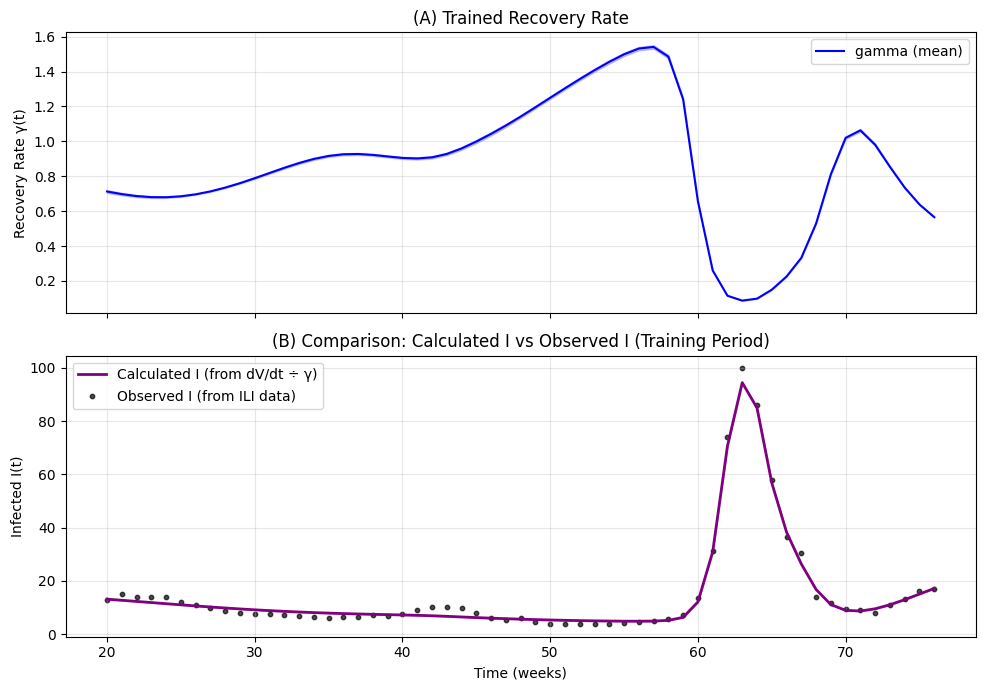

In [ ]:
def ci_mean_std(arr):
    mean = np.mean(arr, axis=0)
    std = np.std(arr, axis=0)
    if arr.shape[0] > 1:
        lower = mean - 1.96 * std / np.sqrt(arr.shape[0])
        upper = mean + 1.96 * std / np.sqrt(arr.shape[0])
    else:
        lower, upper = mean, mean
    return mean, lower, upper

t1 = t_train_PINN.clone().detach().requires_grad_(True)
train_V = mlp_V(t1) * V_train.max().item()
dV_dt_train_tensor = torch.autograd.grad(outputs=train_V.sum(), inputs=t1, create_graph=True)[0]
dV_dt_train_np = dV_dt_train_tensor.detach().cpu().numpy().flatten()

train_I_calculated = []
for i in range(num_sample_parameters):
    gamma_train_i = np.asarray(gamma_histories[i]).flatten()
    gamma_train_i_clipped = np.clip(gamma_train_i, a_min=1e-6, a_max=None)
    I_train_i = dV_dt_train_np / gamma_train_i_clipped
    train_I_calculated.append(I_train_i)

train_I_calculated = np.array(train_I_calculated)
mean_train_I, lower_bound_train_I, upper_bound_train_I = ci_mean_std(train_I_calculated)


mse_train = np.mean((mean_train_I - I_train_raw)**2)
corr_train = np.corrcoef(mean_train_I, I_train_raw[:len(mean_train_I)])[0, 1]

print("--- Training Period Analysis ---")
print(f"Train MSE: {mse_train:.4f}")
print(f"Train Correlation: {corr_train:.4f}")
print("---------------------------------")



t_train_np = t_train_PINN.detach().cpu().numpy().flatten()

gamma_array = np.array(gamma_histories)
gamma_mean = np.mean(gamma_array, axis=0).flatten()
gamma_lower = gamma_mean - 1.96 * np.std(gamma_array, axis=0).flatten() / np.sqrt(gamma_array.shape[0])
gamma_upper = gamma_mean + 1.96 * np.std(gamma_array, axis=0).flatten() / np.sqrt(gamma_array.shape[0])

fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=True)

axes[0].plot(t_train_np, gamma_mean, color='blue', label='gamma (mean)')
axes[0].fill_between(t_train_np, gamma_lower, gamma_upper, color='blue', alpha=0.2)
axes[0].set_ylabel('Recovery Rate γ(t)')
axes[0].set_title('(A) Trained Recovery Rate')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(t_train_np, mean_train_I, color='purple', label='Calculated I (from dV/dt ÷ γ)', linewidth=2)
axes[1].fill_between(t_train_np, lower_bound_train_I, upper_bound_train_I, color='purple', alpha=0.2)
axes[1].scatter(t_train_np, I_train_raw, color='black', s=10, alpha=0.7, label='Observed I (from ILI data)')
axes[1].set_xlabel('Time (weeks)')
axes[1].set_ylabel('Infected I(t)')
axes[1].set_title('(B) Comparison: Calculated I vs Observed I (Training Period)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Save the results

In [ ]:
last_values_df = pd.DataFrame({
    'beta_final': beta_final,
    'beta_mean' : beta_means,
    'kappa': [kappa for kappa in np.array(kappa_histories).flatten()],
    'delta': [delta for delta in np.array(delta_histories).flatten()],
    'gamma': [gamma for gamma in np.array(gamma_last_histories).flatten()]
})
last_values_df
last_values_df.to_excel(matlab_path + "pinn_last_params_list.xlsx", index=False)

In [100]:
gamma_df.to_excel(matlab_path + "pinn_gamma_histories.xlsx", index=False)
gamma_last_df.to_excel(matlab_path + "pinn_gamma_last_histories.xlsx", index=False)

In [ ]:
S_results = pd.DataFrame()
E_results = pd.DataFrame()
I_results = pd.DataFrame()
R_results = pd.DataFrame()
V_results = pd.DataFrame()
Rt_reuslts = pd.DataFrame()

for i in range(num_sample_parameters):
    S_results[f'iter{i+1}'] = pinn_train_histories[i]['S']
    E_results[f'iter{i+1}'] = pinn_train_histories[i]['E']
    I_results[f'iter{i+1}'] = pinn_train_histories[i]['I']
    R_results[f'iter{i+1}'] = pinn_train_histories[i]['R']
    Rt_reuslts[f'iter{i+1}'] = pinn_train_histories[i]['Rt']

S_results = S_results * N
E_results = E_results * N
I_results = I_results * I_train.max().item() 
R_results = R_results * N
V_results[f'iter{1}'] = V_train_pred.flatten()
Rt_results = Rt_reuslts * rt.max().item()

S_results['mean'] = S_results.mean(axis=1)
E_results['mean'] = E_results.mean(axis=1)
I_results['mean'] = I_results.mean(axis=1)
R_results['mean'] = R_results.mean(axis=1)
Rt_results['mean'] = Rt_results.mean(axis=1)


S_results['lower'] = S_results['mean'] - 1.96 * S_results.std(axis=1) / np.sqrt(100)
S_results['upper'] = S_results['mean'] + 1.96 * S_results.std(axis=1) / np.sqrt(100)
E_results['lower'] = E_results['mean'] - 1.96 * E_results.std(axis=1) / np.sqrt(100)
E_results['upper'] = E_results['mean'] + 1.96 * E_results.std(axis=1) / np.sqrt(100)
I_results['lower'] = I_results['mean'] - 1.96 * I_results.std(axis=1) / np.sqrt(100)
I_results['upper'] = I_results['mean'] + 1.96 * I_results.std(axis=1) / np.sqrt(100)
R_results['lower'] = R_results['mean'] - 1.96 * R_results.std(axis=1) / np.sqrt(100)
R_results['upper'] = R_results['mean'] + 1.96 * R_results.std(axis=1) / np.sqrt(100)
Rt_results['lower'] = Rt_results['mean'] - 1.96 * Rt_results.std(axis=1) / np.sqrt(100)
Rt_results['upper'] = Rt_results['mean'] + 1.96 * Rt_results.std(axis=1) / np.sqrt(100)

output_path = matlab_path + "pinn_results.xlsx"
with pd.ExcelWriter(output_path) as writer:
    S_results.to_excel(writer, sheet_name='S_results', index=False)
    E_results.to_excel(writer, sheet_name='E_results', index=False)
    I_results.to_excel(writer, sheet_name='I_results', index=False)
    R_results.to_excel(writer, sheet_name='R_results', index=False)
    V_results.to_excel(writer, sheet_name='V_results', index=False)
    Rt_results.to_excel(writer, sheet_name='Rt_results', index=False)

loss_records_df = pd.DataFrame(all_loss_records)
loss_records_df.to_excel(matlab_path + "pinn_loss_records.xlsx", index=False)

beta_t_df = pd.DataFrame(beta_histories)
kappa_df = pd.DataFrame(kappa_histories, columns=[f'kappa_{i+1}' for i in range(len(kappa_histories[0]))])
delta_df = pd.DataFrame(delta_histories, columns=[f'delta_{i+1}' for i in range(len(delta_histories[0]))])
beta_t_df.to_excel(matlab_path + "pinn_beta_t_histories.xlsx", index=False)
kappa_df.to_excel(matlab_path + "pinn_kappa_histories.xlsx", index=False)
delta_df.to_excel(matlab_path + "pinn_delta_histories.xlsx", index=False)


C:\Users\Jihyeon Kim\AppData\Local\Temp\ipykernel_24188\2256162959.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  S_results['mean'] = S_results.mean(axis=1)
C:\Users\Jihyeon Kim\AppData\Local\Temp\ipykernel_24188\2256162959.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_results['mean'] = E_results.mean(axis=1)
C:\Users\Jihyeon Kim\AppData\Local\Temp\ipykernel_24188\2256162959.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor p

In [102]:
beta_t_df = pd.DataFrame(beta_histories)
beta_t_df.to_excel(matlab_path + "pinn_beta_t_histories.xlsx", index=False)